In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import copy
import joblib
import zlib
import msgpack
import gzip
import io

In [2]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

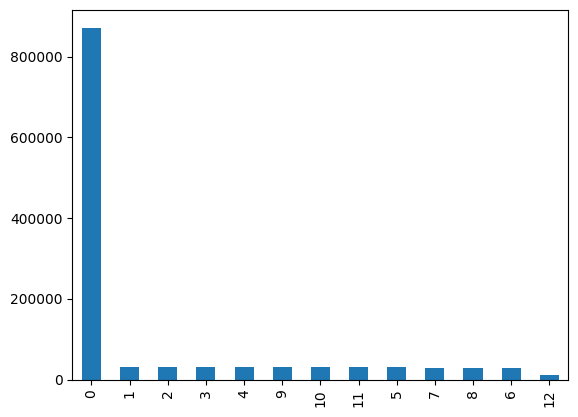

In [3]:
pd.value_counts(df['Activity']).plot.bar()

In [4]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [5]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])
workers_info = []
energy_for_edge_at_start = 100000

In [6]:
for i in range(5):
    for j in range(5):
        worker_data = pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id = i
        worker_score = 0
        worker_coef = 0
        worker_intercept = 0
        worker_energy = []
        energy_acc = []
        energy = energy_for_edge_at_start
        workers_info.append([worker_data, worker_id, worker_coef, worker_score,
                             worker_intercept, worker_energy, energy_acc, energy])

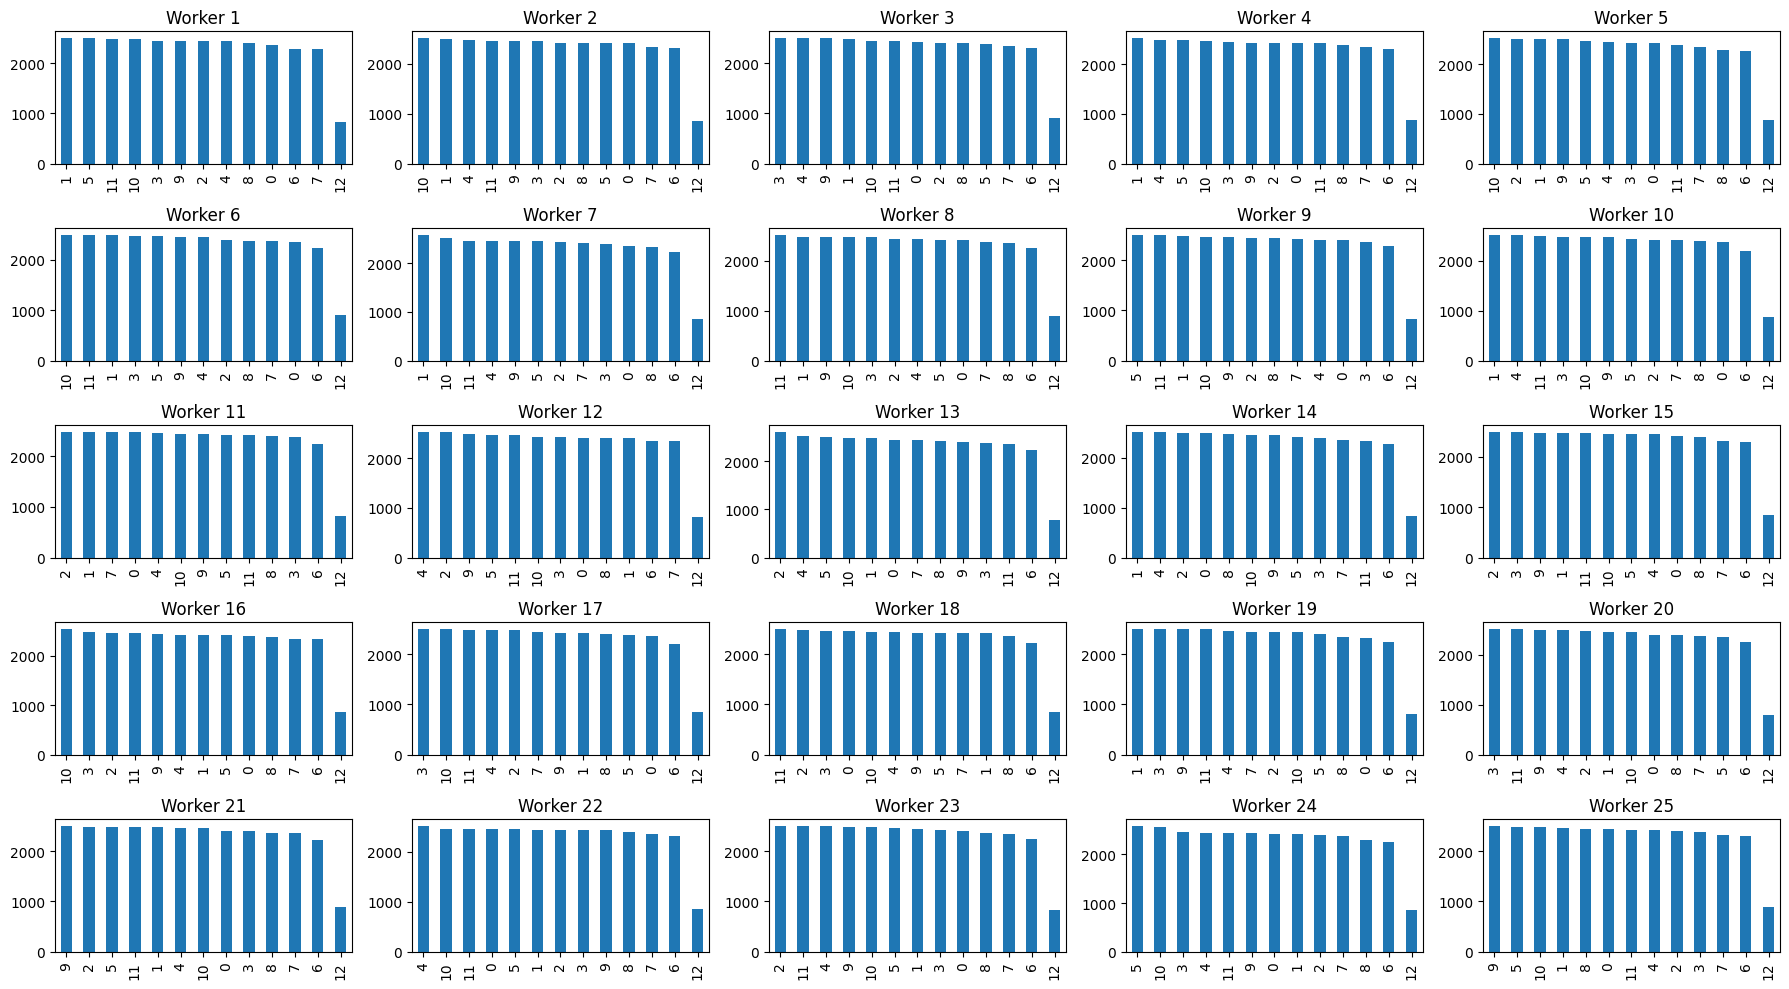

In [7]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()

In [8]:
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        # Use joblib.load to handle non-compressed models
        model = joblib.load(io.BytesIO(message))
        return model, None
    except Exception:
        pass

    try:
        # Handle gzipped models
        decompressed_byte_array = zlib.decompress(message)
        model = joblib.load(io.BytesIO(decompressed_byte_array))
        return model, None
    except Exception:
        pass

    # Return default values if extraction fails
    return None, None


def compress(model):
    try:
        # Save the model to a BytesIO object using joblib.dump
        model_bytesio = io.BytesIO()
        joblib.dump(model, model_bytesio)

        # Get the serialized model bytes
        model_bytes = model_bytesio.getvalue()

        # Compress the serialized model using gzip
        compressed_model = gzip.compress(model_bytes)

        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception:
        return None

In [9]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration = 0.01
num_of_workers = 25

def energy_for_transmit(data):
    power = 1
    # energy = power * time = time = data / power = data
    return data

def terminate(accuracy, best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

In [10]:
def local_worker_training(worker_num, global_model):
    # Shuffle the data before splitting
    workers_info[worker_num][0] = workers_info[worker_num][0].sample(frac=1, random_state=42)

    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

    # Initialize variables before the if-else block
    energy_consumption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_consumption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) +
                                                          sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train):
            sample_weights = np.repeat(sample_weights, len(lX_train) // len(sample_weights) + 1)[:len(lX_train)]

    else:
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_consumption_in_local += max_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_consumption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_consumption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_rounds,
          "energy remaining:", workers_info[worker_num][7])


In [11]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [12]:
def cal_battery_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100


In [13]:
def cal_edge_score():
    w1 = 0.4
    w2 = 0.6
    for i in range(num_of_workers):
        workers_info[i][3] = w1 * workers_info[i][6][-1] + w2 * cal_battery_life(workers_info[i][7])

# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge = i * 5
        for j in range(1, 5):
            if workers_info[i * 5 + j][3] > workers_info[max_score_edge][3]:
                max_score_edge = i * 5 + j
        cluster_heads[i] = max_score_edge

In [14]:
def adaptive_learning_rate(learning_rate, current_accuracy, previous_accuracy):
    # Adjust the learning rate based on the change in accuracy
    if current_accuracy > previous_accuracy:
        return learning_rate * 1.2  # Increase learning rate by 20% for improvement
    else:
        return learning_rate * 0.8  # Decrease learning rate by 20% for decline


In [17]:
def global_aggregation(global_model, learning_rate):
    training_workers(global_model)  # Pass the global_model to training_workers
    cal_edge_score()
    cal_clusters_head()

    # Use MLPClassifier (neural network) instead of RandomForestClassifier
    new_global_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

    # Combine the weights and biases of contributing workers
    combined_weights = None
    combined_biases = None
    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model, _ = extract(workers_info[i][2])  # extract returns a tuple

        if worker_model:
            # Extract the weights and biases from the worker's neural network
            weights, biases = worker_model.coefs_, worker_model.intercepts_

            # Combine the weights and biases
            if combined_weights is None:
                combined_weights = weights
                combined_biases = biases
            else:
                combined_weights = [cw + w for cw, w in zip(combined_weights, weights)]
                combined_biases = [cb + b for cb, b in zip(combined_biases, biases)]

            num_contributing_workers += 1

    # Average the combined weights and biases
    if num_contributing_workers > 0:
        combined_weights = [cw / num_contributing_workers for cw in combined_weights]
        combined_biases = [cb / num_contributing_workers for cb in combined_biases]

        # Set the combined weights and biases to the new_global_model
        new_global_model.coefs_ = combined_weights
        new_global_model.intercepts_ = combined_biases

        # Check if global_model is not None before performing updates
        if global_model is not None and learning_rate is not None:
            # Update the global_model with the combined weights and biases
            global_model.coefs_ = [
                (1 - learning_rate) * old_coef + learning_rate * new_coef
                for old_coef, new_coef in zip(global_model.coefs_, new_global_model.coefs_)
            ]
            global_model.intercepts_ = [
                (1 - learning_rate) * old_intercept + learning_rate * new_intercept
                for old_intercept, new_intercept in zip(global_model.intercepts_, new_global_model.intercepts_)
            ]

    return new_global_model

In [18]:
max_global_rounds = 10
acc = []
global_model = None  # Initialize global_model outside the loop
learning_rate = 0.1  # Set an initial learning rate

for i in range(max_global_rounds):
    global_model, learning_rate = global_aggregation(global_model, learning_rate)  # Pass the current global_model
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)

local worker: 0 acc: 0.8996666666666666 round no: 100 energy remaining: 99998.0
local worker: 1 acc: 0.9043333333333333 round no: 100 energy remaining: 99822.0
local worker: 2 acc: 0.905 round no: 100 energy remaining: 99998.0
local worker: 3 acc: 0.8973333333333333 round no: 100 energy remaining: 99998.0
local worker: 4 acc: 0.902 round no: 100 energy remaining: 99998.0
local worker: 5 acc: 0.9046666666666666 round no: 100 energy remaining: 99822.0
local worker: 6 acc: 0.9023333333333333 round no: 100 energy remaining: 99998.0
local worker: 7 acc: 0.9043333333333333 round no: 100 energy remaining: 99998.0
local worker: 8 acc: 0.9096666666666666 round no: 100 energy remaining: 99998.0
local worker: 9 acc: 0.9031666666666667 round no: 100 energy remaining: 99998.0
local worker: 10 acc: 0.9071666666666667 round no: 100 energy remaining: 99998.0
local worker: 11 acc: 0.9001666666666667 round no: 100 energy remaining: 99998.0
local worker: 12 acc: 0.8928333333333334 round no: 100 energy re

TypeError: cannot unpack non-iterable MLPClassifier object

In [ ]:
total_energy_per_round = []
energy_per_round = []
total_energy = 0

# Assuming all workers have the same number of rounds
num_rounds = min(len(workers_info[j][5]) for j in range(num_of_workers))

for i in range(num_rounds):
    energy = 0
    for j in range(num_of_workers):
        # Check if the list has enough elements before accessing
        if i < len(workers_info[j][5]):
            total_energy += workers_info[j][5][i]
            energy += workers_info[j][5][i]

    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)

energy_per_round


[]

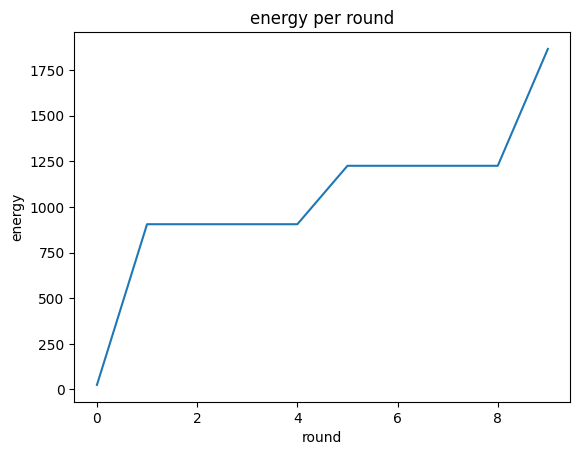

In [ ]:
plt.plot(energy_per_round)
plt.xlabel("round")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()

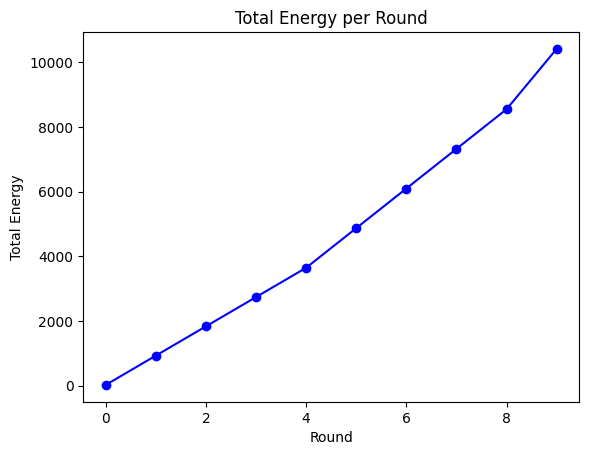

In [ ]:
import matplotlib.pyplot as plt

# Assuming total_energy_per_round is already defined
plt.plot(total_energy_per_round, marker='o', linestyle='-', color='b')  # Customize markers, linestyle, and color
plt.xlabel("Round")
plt.ylabel("Total Energy")
plt.title("Total Energy per Round")
plt.show()


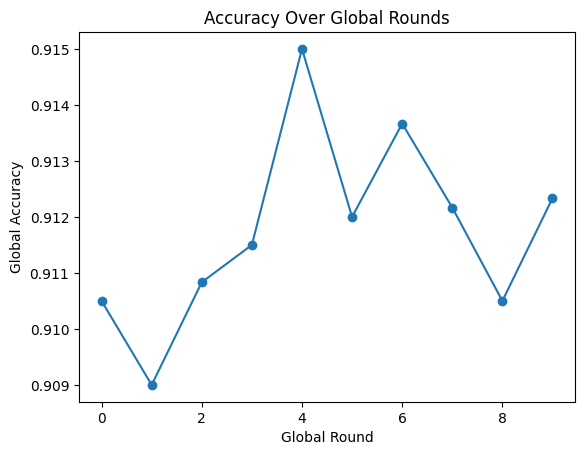

In [ ]:
plt.plot(range(max_global_rounds), acc, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Accuracy Over Global Rounds")
plt.show()


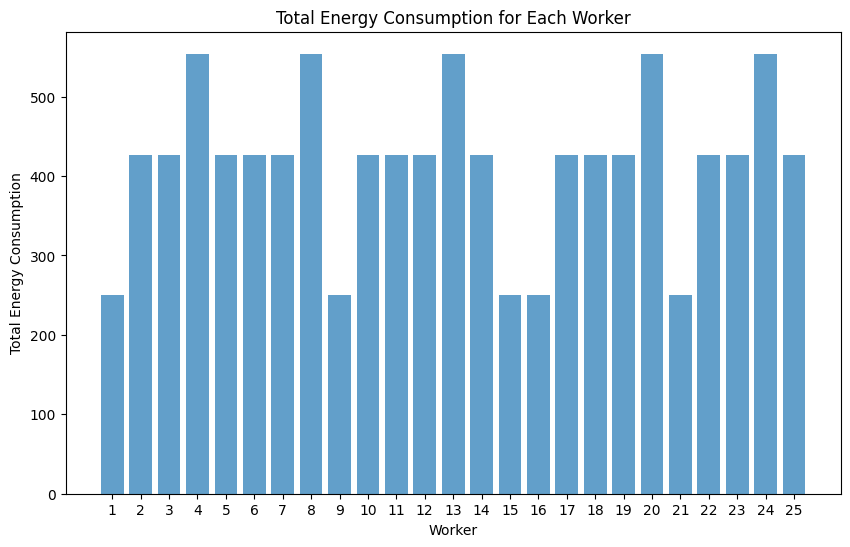

In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the total energy consumption for each worker over local rounds
total_energy_per_worker = [sum(workers_info[i][5]) for i in range(num_of_workers)]

# Plotting a bar graph
ax.bar(range(1, num_of_workers + 1), total_energy_per_worker, align='center', alpha=0.7)
ax.set_xticks(range(1, num_of_workers + 1))
ax.set_xlabel('Worker')
ax.set_ylabel('Total Energy Consumption')
ax.set_title('Total Energy Consumption for Each Worker')

plt.show()


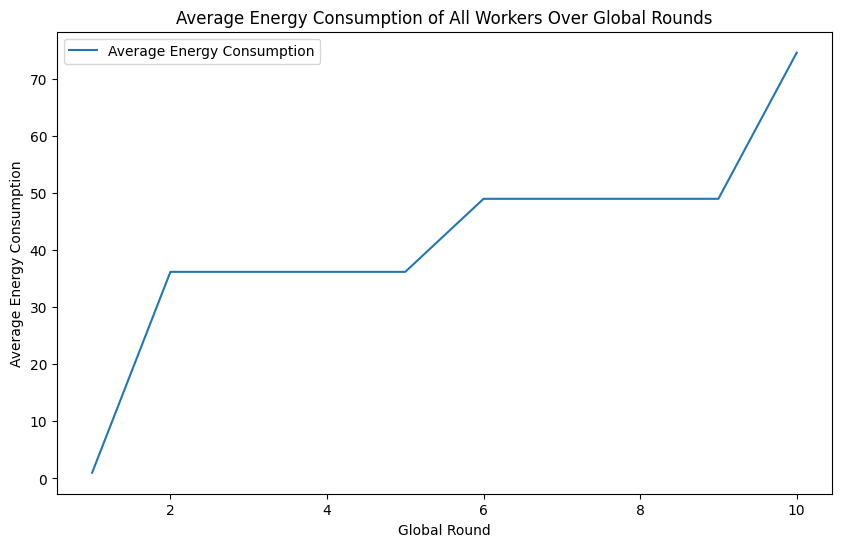

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list `workers_info` that contains information about each worker's energy consumption

# Calculate the average energy consumption for each global round
average_energy_consumption_per_round = np.mean([worker_info[5][:max_global_rounds] for worker_info in workers_info], axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, max_global_rounds + 1), average_energy_consumption_per_round, label='Average Energy Consumption')
ax.set_xlabel('Global Round')
ax.set_ylabel('Average Energy Consumption')
ax.legend()
plt.title('Average Energy Consumption of All Workers Over Global Rounds')
plt.show()
